In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression

from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier

from statistics import mean

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer

# Exploratory Data Analysis
The raw data is of a simple format, consisting of only 2 columns. The first is the person's personality type, and the second contains 50 of the person's comments on a forum.

In [2]:
df = pd.read_csv('data/mbti.csv')
print(df.head())

   type                                              posts
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...
1  ENTP  'I'm finding the lack of me in these posts ver...
2  INTP  'Good one  _____   https://www.youtube.com/wat...
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...
4  ENTJ  'You're fired.|||That's another silly misconce...


First, we check the distribution of personality types.

<AxesSubplot:xlabel='type', ylabel='count'>

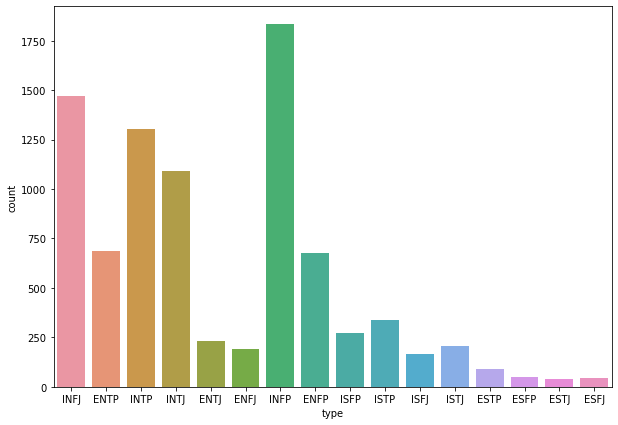

In [3]:
plt.figure(figsize=(10,7))
sns.countplot(data=df, x='type')

The classes are severely imbalanced, with INFP having more than 1750 entries, while ESTJ has less than 250. We will address this later on when required.

The raw data contains only 2 columns, so we will need to generate more numerical data ourselves using the comments.
One of the obvious variables when it comes to people's comments is the length of comments. However, the length of individual words may skew this, so for more accuracy, we find the average number of words used per comment for each person.

In [4]:
df['words_per_comment'] = df['posts'].apply(lambda x: len(x.split())/50)
print(df.head())

   type                                              posts  words_per_comment
0  INFJ  'http://www.youtube.com/watch?v=qsXHcwe3krw|||...              11.12
1  ENTP  'I'm finding the lack of me in these posts ver...              23.40
2  INTP  'Good one  _____   https://www.youtube.com/wat...              16.72
3  INTJ  'Dear INTP,   I enjoyed our conversation the o...              21.28
4  ENTJ  'You're fired.|||That's another silly misconce...              19.34


Using box plots arranged by mean and median, we can see which personalities are more likely to have longer comments.

<AxesSubplot:xlabel='type', ylabel='words_per_comment'>

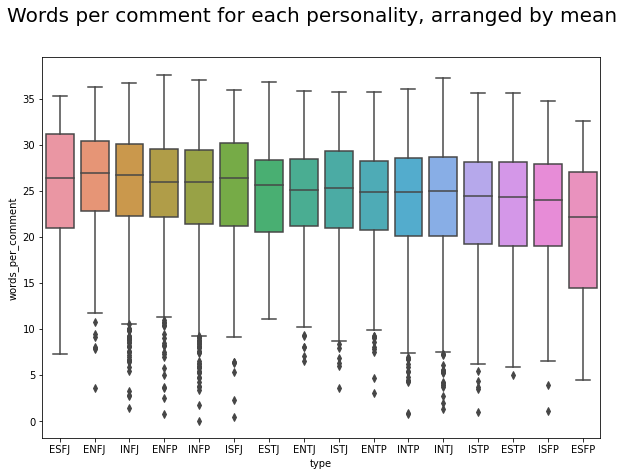

In [5]:
df["type"].astype("category")
ranks = df.groupby("type")["words_per_comment"].mean().fillna(0).sort_values()[::-1].index

plt.figure(figsize=(10,7)).suptitle("Words per comment for each personality, arranged by mean", fontsize=20)
sns.boxplot(x='type', y='words_per_comment', data=df, order=ranks)

<AxesSubplot:xlabel='type', ylabel='words_per_comment'>

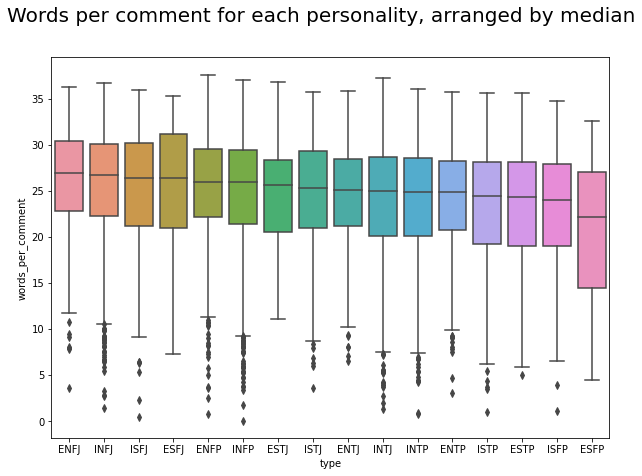

In [6]:
ranks = df.groupby("type")["words_per_comment"].median().fillna(0).sort_values()[::-1].index

plt.figure(figsize=(10,7)).suptitle("Words per comment for each personality, arranged by median", fontsize=20)
sns.boxplot(x='type', y='words_per_comment', data=df, order=ranks)

Immediately we can see a noticeable distinction: the personalities with "F" (Feeling) and "J" (Judging) have high mean and median number of words per comment.

Following that are the ENFP and INFP personalities. Could it be possible that "F" (Feeling) personalities make longer comments?

However, when we look at the lower end, ISFP and ESFP consistently have the lowest mean and median number of words per comment. Maybe it is more accurate to say that "F" (Feeling) personalities are more extreme in their length of comments: either they say a lot, or very little.

# Rudimentary word frequency analysis
Next, we will generate new numerical data derived from the frequency of certain words. Similar to how it was done earlier, we will find the average number of SPECIFIC words per comment. A reasonable guess at some words that may separate the personalities would be "think", "feel", and "judge" -- the very names of the personality categories. While we include these words in past tense ("thought", "felt", "judged"), it is important to exclude "thinking", "feeling", and "judging" specifically, as the comments are from a personality forum, and these words may be used to refer to the other personality types directly.

We also introduced control variables, namely the most common noun "time", the most common verb "be", and the articles "a/an/the".

C:\Users\alist\anaconda3\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
C:\Users\alist\anaconda3\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
C:\Users\alist\anaconda3\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()
C:\Users\alist\anaconda3\lib\site-packages\seaborn\axisgrid.py:1740: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  f.tight_layout()


Text(0.5, 0.98, '"Think/thought" frequency vs comment length')

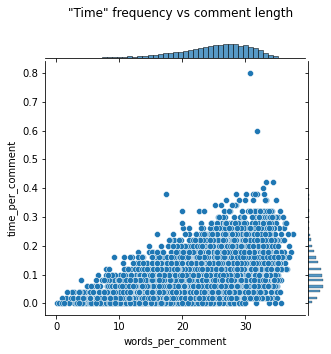

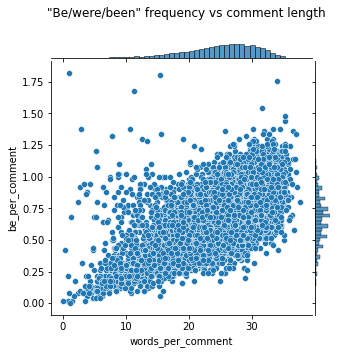

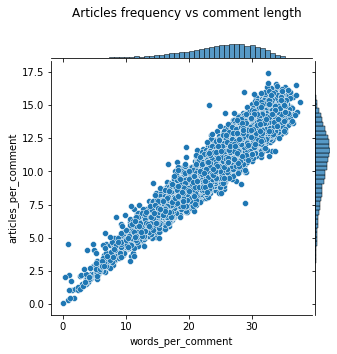

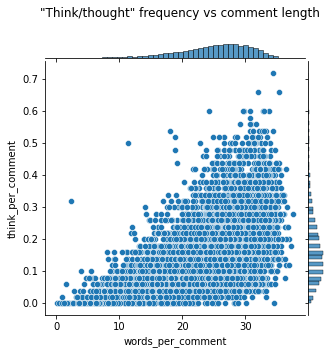

In [7]:
df['time_per_comment'] = df['posts'].apply(lambda x: x.count('time')/50)
df['be_per_comment'] = df['posts'].apply(lambda x: (x.count('be')+x.count('were')+x.count('been'))/50)
df['articles_per_comment'] = df['posts'].apply(lambda x: (x.count('a')+x.count('an')+x.count('the'))/50)

df['think_per_comment'] = df['posts'].apply(lambda x: (x.count('think')+x.count('thought'))/50)
df['feel_per_comment'] = df['posts'].apply(lambda x: (x.count('feel')+x.count('felt'))/50)
df['judge_per_comment'] = df['posts'].apply(lambda x: (x.count('judge')+x.count('judged'))/50)

sns.jointplot(x='words_per_comment', y='time_per_comment', data=df, height=5, ratio=14).figure.suptitle("\"Time\" frequency vs comment length")

sns.jointplot(x='words_per_comment', y='be_per_comment', data=df, height=5, ratio=14).figure.suptitle("\"Be/were/been\" frequency vs comment length")

sns.jointplot(x='words_per_comment', y='articles_per_comment', data=df, height=5, ratio=14).figure.suptitle("Articles frequency vs comment length")

sns.jointplot(x='words_per_comment', y='think_per_comment', data=df, height=5, ratio=14).figure.suptitle("\"Think/thought\" frequency vs comment length")


Note the interesting linear upper bound for specific words per comment against total words per comment. A very rough guess would be that if the words "think"/"thought" come up in a comment, their frequency usually cannot exceed ~0.2%.

As for the control variables, the most common noun "time" follows the same pattern, albeit at much lower frequency, and the very high frequency verbs "be/were/been" and articles "a/an/the" become more well-formed linear patterns as frequency increases.

Next we will separate the dataset into I-E, N-S, T-F, and J-P dichotomies. It is likely easier to predict if something is one of two types, rather than one of sixteen types. For ease of reusability, we map the personality's name string to a "4-hot" encoding, one for each dichotomy.

In [8]:
map1 = {"I": 0, "E": 1}
map2 = {"N": 0, "S": 1}
map3 = {"T": 0, "F": 1}
map4 = {"J": 0, "P": 1}

# Read the nth position of the string e.g. 0th position either contains I or E
df['I-E'] = df['type'].astype(str).str[0]
# Apply the mapping to integers - I is 0, E is 1
df['I-E'] = df['I-E'].map(map1)

df['N-S'] = df['type'].astype(str).str[1]
df['N-S'] = df['N-S'].map(map2)

df['T-F'] = df['type'].astype(str).str[2]
df['T-F'] = df['T-F'].map(map3)

df['J-P'] = df['type'].astype(str).str[3]
df['J-P'] = df['J-P'].map(map4)

print(df[['type','I-E','N-S','T-F','J-P']])

      type  I-E  N-S  T-F  J-P
0     INFJ    0    0    1    0
1     ENTP    1    0    0    1
2     INTP    0    0    0    1
3     INTJ    0    0    0    0
4     ENTJ    1    0    0    0
...    ...  ...  ...  ...  ...
8670  ISFP    0    1    1    1
8671  ENFP    1    0    1    1
8672  INTP    0    0    0    1
8673  INFP    0    0    1    1
8674  INFP    0    0    1    1

[8675 rows x 5 columns]


The classification model we chose was Random Forest. Firstly we attempt to classify all 16 personalities at a go:

Random Forest prediction on all 16 personalities
Accuracy on train set:  1.0
Accuracy on test set:  0.1987090825265099


<AxesSubplot:>

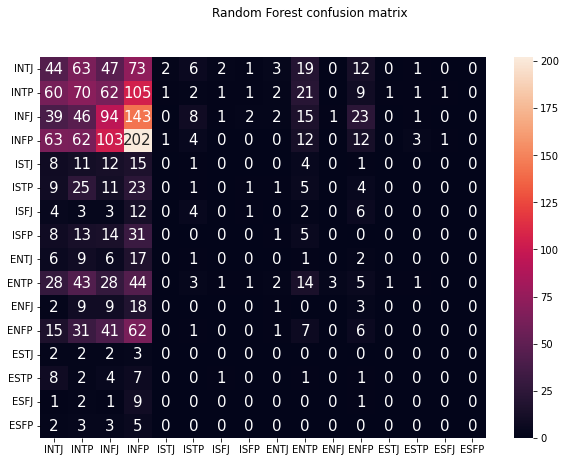

In [9]:
X = df.drop(['type','posts','I-E','N-S','T-F','J-P'], axis=1).values
y = df['type'].values

X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.25, random_state=5)
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)

print("Random Forest prediction on all 16 personalities")
print("Accuracy on train set: ", random_forest.score(X_train, y_train))
print("Accuracy on test set: ", random_forest.score(X_test, y_test))


y_test_pred = random_forest.predict(X_test)

plt.figure(figsize=(10,7)).suptitle("Random Forest confusion matrix")
perslist = ['INTJ', 'INTP', 'INFJ', 'INFP', 'ISTJ', 'ISTP', 'ISFJ', 'ISFP', 'ENTJ', 'ENTP', 'ENFJ', 'ENFP', 'ESTJ', 'ESTP', 'ESFJ', 'ESFP']
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels=perslist), 
    annot = True, fmt=".0f", annot_kws={"size": 15}, xticklabels=perslist, yticklabels=perslist)

We note that the model is overpredicting the "IN" personalities, as seen from the first 4 columns. Classifying all 16 personalities at the same time gets us a low prediction accuracy. To attempt to improve the accuracy, we reduce our classification options to 2 personalities.

Random Forest prediction on the dichotomy:  I-E
Accuracy on train set:  1.0
Accuracy on test set:  0.7708621484555095 

Random Forest prediction on the dichotomy:  N-S
Accuracy on train set:  0.9998462957270212
Accuracy on test set:  0.8616874135546335 

Random Forest prediction on the dichotomy:  T-F
Accuracy on train set:  1.0
Accuracy on test set:  0.6173351775011526 

Random Forest prediction on the dichotomy:  J-P
Accuracy on train set:  1.0
Accuracy on test set:  0.5818349469801752 



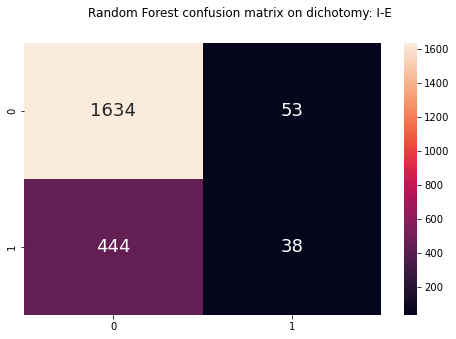

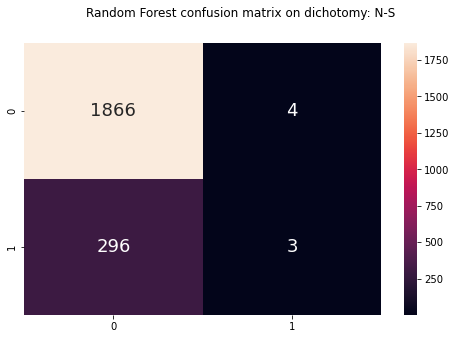

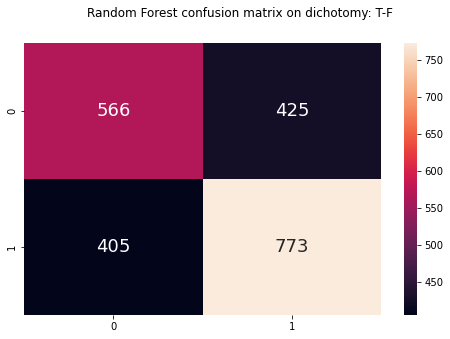

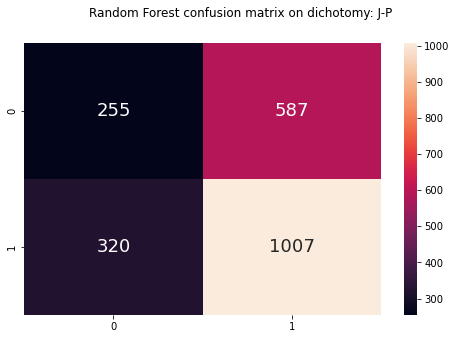

In [10]:
for dich in ['I-E','N-S','T-F','J-P']:
    X = df.drop(['type','posts',dich], axis=1).values
    y = df[dich].values

    X_train,X_test,y_train,y_test=train_test_split(X,y,test_size = 0.25, random_state=5)
    random_forest = RandomForestClassifier()
    random_forest.fit(X_train, y_train)

    print("Random Forest prediction on the dichotomy: ", dich)
    print("Accuracy on train set: ", random_forest.score(X_train, y_train))
    print("Accuracy on test set: ", random_forest.score(X_test, y_test), "\n")

    y_test_pred = random_forest.predict(X_test)

    title = "Random Forest confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})

J-P has a lower accuracy than the others. A guess would be that J-P is hard to predict for, as there are many context-dependent ways to describe a judged/perceived situation.

Now we will relook at the distribution of classes in the raw data. Particularly we suspect that the "IN" personalities are over-represented, since the Random Forest model over-predicts for it.

<AxesSubplot:xlabel='type', ylabel='count'>

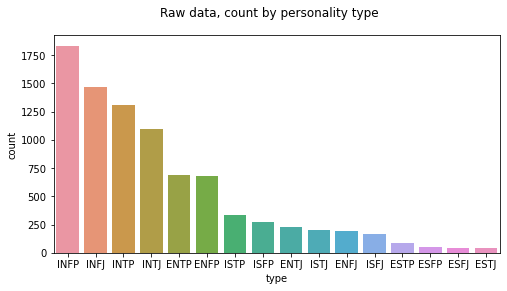

In [11]:
plt.figure(figsize=(8,4)).suptitle("Raw data, count by personality type")
sns.countplot(data=df, x='type', order = df['type'].value_counts().index)


As expected, the classes with the highest counts are the "IN" personalities. The cause for the model's low accuracies may be due to the fact that we have severely imbalanced classes. We can balance them out by using SMOTE oversampler and Tomek cleaning, which are provided by "imbalanced-learn". This is a package similar to scikit-learn but accomodating specifically to imbalanced data.

<AxesSubplot:ylabel='Count'>

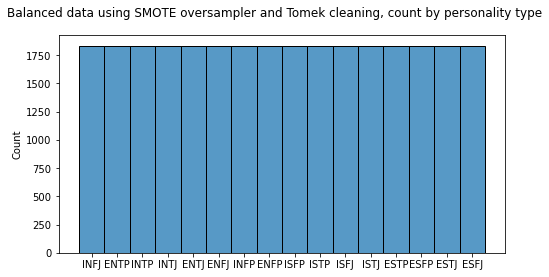

In [12]:
X = df.drop(['type','posts'], axis=1).values
y = df['type'].values
X_oversample, y_oversample = SMOTETomek().fit_resample(X, y)

plt.figure(figsize=(8,4)).suptitle("Balanced data using SMOTE oversampler and Tomek cleaning, count by personality type")
sns.histplot(data=y_oversample)

"imbalanced-learn" also provides balanced versions of ML algorithms. With the new balanced data, we will re-attempt ML on a Balanced Random Forest. As a sanity check, we will cross-check the model with the original unbalanced data. Note that the model is only trained on the balanced sets, so the unbalanced data's train set accuracy will not be 100%. Instead, the unbalanced data's train and test sets (named 75% and 25% sets) should have similar accuracy.

Balanced Random Forest prediction on all 16 personalities:
Accuracy on train set (balanced):  1.0
Accuracy on test set (balanced):  0.7211566833874299 

Accuracy on 75% set (raw data):  0.7792806640024593
Accuracy on 25% set (raw data):  0.751959428307976


<AxesSubplot:>

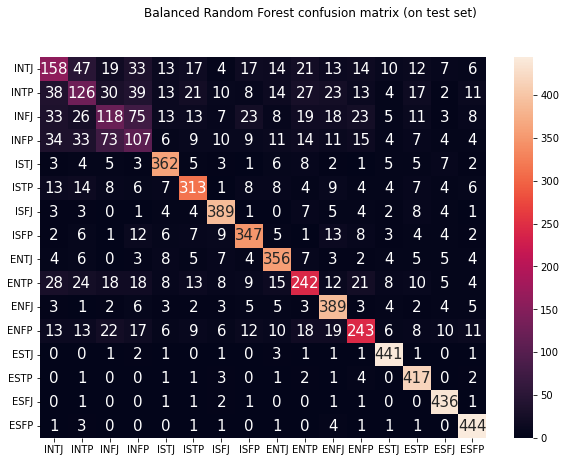

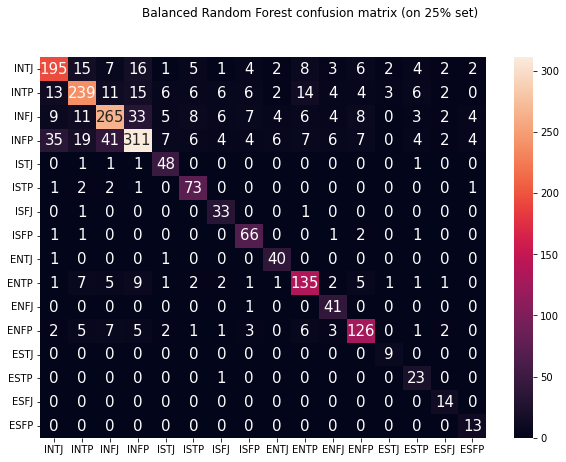

In [13]:
X = df.drop(['type','posts','I-E','N-S','T-F','J-P'], axis=1).values
y = df['type'].values
X_resampled, y_resampled = SMOTETomek().fit_resample(X, y)

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size = 0.25, random_state=5)
random_forest = BalancedRandomForestClassifier()
random_forest.fit(X_train, y_train)

print("Balanced Random Forest prediction on all 16 personalities:")
print("Accuracy on train set (balanced): ", random_forest.score(X_train, y_train))
print("Accuracy on test set (balanced): ", random_forest.score(X_test, y_test), "\n")

Ximb_train,Ximb_test,yimb_train,yimb_test=train_test_split(X,y,test_size = 0.25, random_state=5)

print("Accuracy on 75% set (raw data): ", random_forest.score(Ximb_train, yimb_train))
print("Accuracy on 25% set (raw data): ", random_forest.score(Ximb_test, yimb_test))

y_test_pred = random_forest.predict(X_test)
yimb_test_pred = random_forest.predict(Ximb_test)

plt.figure(figsize=(10,7)).suptitle("Balanced Random Forest confusion matrix (on test set)")
perslist = ['INTJ', 'INTP', 'INFJ', 'INFP', 'ISTJ', 'ISTP', 'ISFJ', 'ISFP', 'ENTJ', 'ENTP', 'ENFJ', 'ENFP', 'ESTJ', 'ESTP', 'ESFJ', 'ESFP']
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels=perslist), 
    annot = True, fmt=".0f", annot_kws={"size": 15}, xticklabels=perslist, yticklabels=perslist)

plt.figure(figsize=(10,7)).suptitle("Balanced Random Forest confusion matrix (on 25% set)")
sns.heatmap(confusion_matrix(yimb_test, yimb_test_pred, labels=perslist), 
    annot = True, fmt=".0f", annot_kws={"size": 15}, xticklabels=perslist, yticklabels=perslist)

Balanced Random Forest prediction on the dichotomy:  I-E
Accuracy on train set:  1.0
Accuracy on test set:  0.8410288193368454 

Balanced Random Forest prediction on the dichotomy:  N-S
Accuracy on train set:  1.0
Accuracy on test set:  0.9179022515101593 

Balanced Random Forest prediction on the dichotomy:  T-F
Accuracy on train set:  1.0
Accuracy on test set:  0.6827515400410678 

Balanced Random Forest prediction on the dichotomy:  J-P
Accuracy on train set:  1.0
Accuracy on test set:  0.665667808219178 



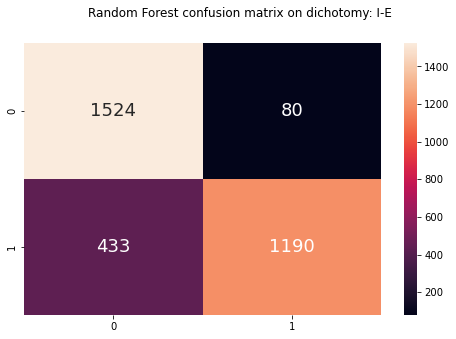

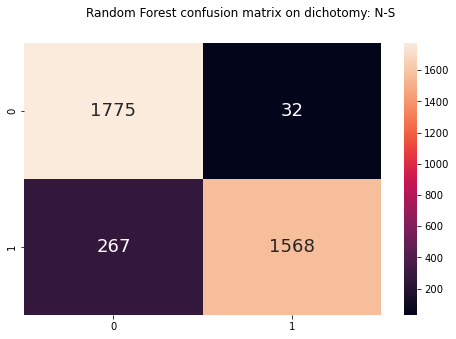

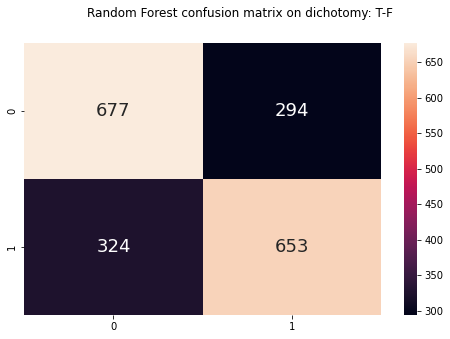

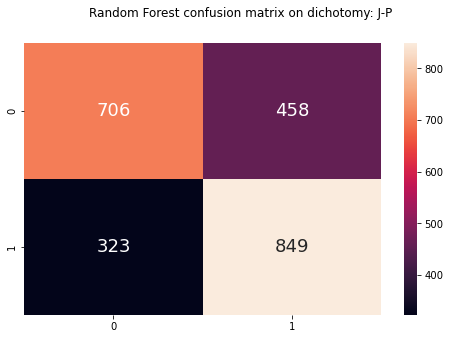

In [14]:
for dich in ['I-E','N-S','T-F','J-P']:
    X = df.drop(['type','posts','I-E','N-S','T-F','J-P'], axis=1).values
    y = df[dich].values
    X_resampled, y_resampled = SMOTETomek().fit_resample(X, y)
    
    X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size = 0.25, random_state=5)
    random_forest = BalancedRandomForestClassifier()
    random_forest.fit(X_train, y_train)

    print("Balanced Random Forest prediction on the dichotomy: ", dich)
    print("Accuracy on train set: ", random_forest.score(X_train, y_train))
    print("Accuracy on test set: ", random_forest.score(X_test, y_test), "\n")

    y_test_pred = random_forest.predict(X_test)

    title = "Random Forest confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})

There is a significant improvement in the accuracy of the Balanced Random Forest with balanced classes in the data. The accuracy of prediction for the dichotomies have a slight improvement.

Next we will try K-Nearest Neighbours

K-Nearest Neighbours prediction on all 16 personalities
Accuracy on train set:  0.8608953747217413
Accuracy on test set:  0.6570707820151358


<AxesSubplot:>

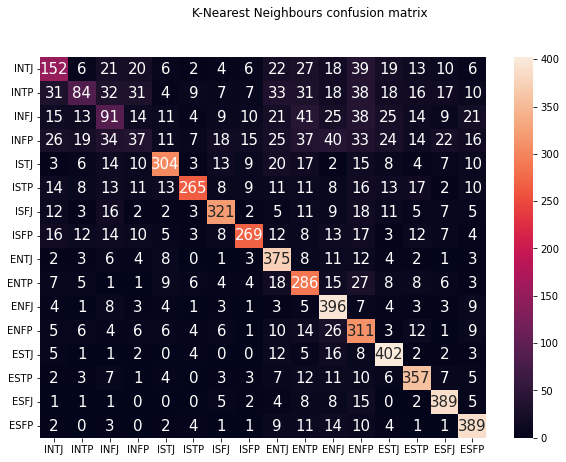

In [15]:
X = df.drop(['type','posts','I-E','N-S','T-F','J-P'], axis=1).values
y = df['type'].values
X_resampled, y_resampled = SMOTETomek().fit_resample(X, y)

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size = 0.25, random_state=5)
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(X_train, y_train)

print("K-Nearest Neighbours prediction on all 16 personalities")
print("Accuracy on train set: ",knn.score(X_train, y_train))
print("Accuracy on test set: ",knn.score(X_test, y_test))

y_test_pred = knn.predict(X_test)

plt.figure(figsize=(10,7)).suptitle("K-Nearest Neighbours confusion matrix")
perslist = ['INTJ', 'INTP', 'INFJ', 'INFP', 'ISTJ', 'ISTP', 'ISFJ', 'ISFP', 'ENTJ', 'ENTP', 'ENFJ', 'ENFP', 'ESTJ', 'ESTP', 'ESFJ', 'ESFP']
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels=perslist), 
    annot = True, fmt=".0f", annot_kws={"size": 15}, xticklabels=perslist, yticklabels=perslist)

K-Nearest Neighbours prediction on the dichotomy:  I-E
Accuracy on train set:  0.9757085020242915
Accuracy on test set:  0.7723450638430396 

K-Nearest Neighbours prediction on the dichotomy:  N-S
Accuracy on train set:  0.987120935330654
Accuracy on test set:  0.8512328767123287 

K-Nearest Neighbours prediction on the dichotomy:  T-F
Accuracy on train set:  0.8174644021272945
Accuracy on test set:  0.6464230571281523 

K-Nearest Neighbours prediction on the dichotomy:  J-P
Accuracy on train set:  0.8146545506995528
Accuracy on test set:  0.6412808308091735 



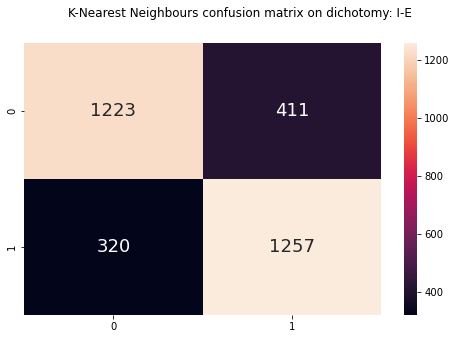

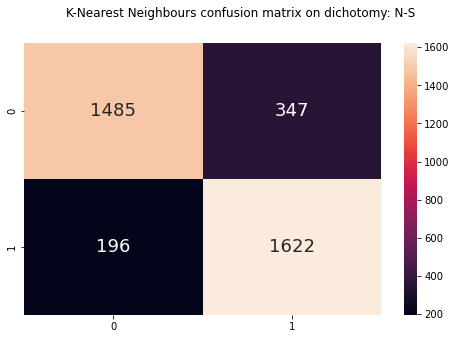

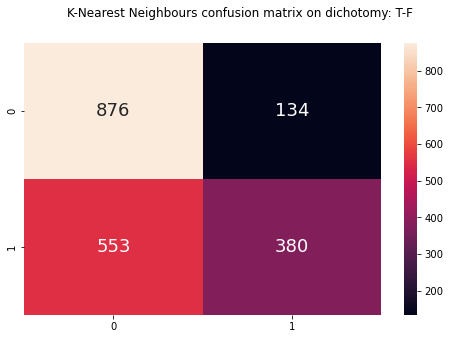

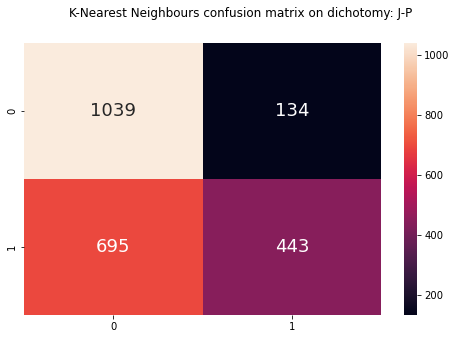

In [16]:
for dich in ['I-E','N-S','T-F','J-P']:
    X = df.drop(['type','posts','I-E','N-S','T-F','J-P'], axis=1).values
    y = df[dich].values
    X_resampled, y_resampled = SMOTETomek().fit_resample(X, y)

    X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size = 0.25, random_state=5)
    knn = KNeighborsClassifier(n_neighbors = 2)
    knn.fit(X_train, y_train)

    print("K-Nearest Neighbours prediction on the dichotomy: ", dich)
    print("Accuracy on train set: ", knn.score(X_train, y_train))
    print("Accuracy on test set: ", knn.score(X_test, y_test), "\n")

    y_test_pred = knn.predict(X_test)

    title = "K-Nearest Neighbours confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, y_test_pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})

K-Nearest Neighbours does not do as well as Balanced Random Forest here when predicting for all 16 personalities. The dichotomy prediction for I-E and N-S is comparable to that of Balanced Random Forest, but for T-F and J-P the accuracy is much lower.

## Sentiment Analysis
Now, we will try using NLTK's sentiment analysis to predict people's MBTI's personality type. This might work as different personality types will have different levels positivity/negativity, so by taking the average sentiment of their past 50 posts, we can try and make use of that as a feature.

We will make use of the in-built pre-trained VADER model for the senntiment analysis.

In [17]:
# Below are a bunch of functions that will be used

# Extracts each post into a single list
def getPosts(df):
    postList = []
    # Using this to check if input has a single row or multiple rows
    try:
        for x in df['posts'].split("|||"):
            postList.append(x)
    except:
        for i in df['posts']:
            for x in i.split("|||"):
                postList.append(x)
        
    return postList

# Extracts each word into a single list
def getWords(df):
    postList = getPosts(df)
    wordList = [word for post in postList for word in nltk.word_tokenize(post)]
    return wordList

# Basic cleaning of the word list
def cleanWords(wordList):
    # Current cleaning operations:
    # - Removal of punctuations
    # - Removal of stopwords
    # - Changing all to lowercase
    stopwords = nltk.corpus.stopwords.words("english")
    filteredList = [w.lower() for w in wordList if w.lower() not in stopwords and w.isalpha()]
    return filteredList

# Functions for calculating average polarity scores
def calcAvgNeg(posts):
    neg = [sia.polarity_scores(post)['neg'] for post in posts]
    return mean(neg)

def calcAvgNeu(posts):
    neu = [sia.polarity_scores(post)['neu'] for post in posts]
    return mean(neu)

def calcAvgPos(posts):
    pos = [sia.polarity_scores(post)['pos'] for post in posts]
    return mean(pos)

def calcAvgComp(posts):
    comp = [sia.polarity_scores(post)['compound'] for post in posts]
    return mean(comp)

In [18]:
# Example sentiment analysis
posts = getPosts(df)
sia = SentimentIntensityAnalyzer()

print(posts[333])
print(sia.polarity_scores(posts[333]))

You're right that INFJs can be very idealistic, but those with a strong Ti can also be very realistic as well, especially if we go into Ti overdrive.     After reading this, I still don't think...
{'neg': 0.0, 'neu': 0.759, 'pos': 0.241, 'compound': 0.8605}


Here we can see a sample sentiment analysis result that will give us a negative, neutral and positive score than range from 0-1 and adds up to 1, and a compound score that ranges from -1 (for negative) and 1 (for positive) indicating the overall sentiment. We will make use of the averages of these values across all posts as features.

In [19]:
# Creating features using the average of each of the scores
df['avgNeg'] = [calcAvgNeg(getPosts(df.iloc[i])) for i in range(len(df))]
df['avgNeu'] = [calcAvgNeu(getPosts(df.iloc[i])) for i in range(len(df))]
df['avgPos'] = [calcAvgPos(getPosts(df.iloc[i])) for i in range(len(df))]
df['avgComp'] = [calcAvgComp(getPosts(df.iloc[i])) for i in range(len(df))]

<AxesSubplot:xlabel='type', ylabel='avgComp'>

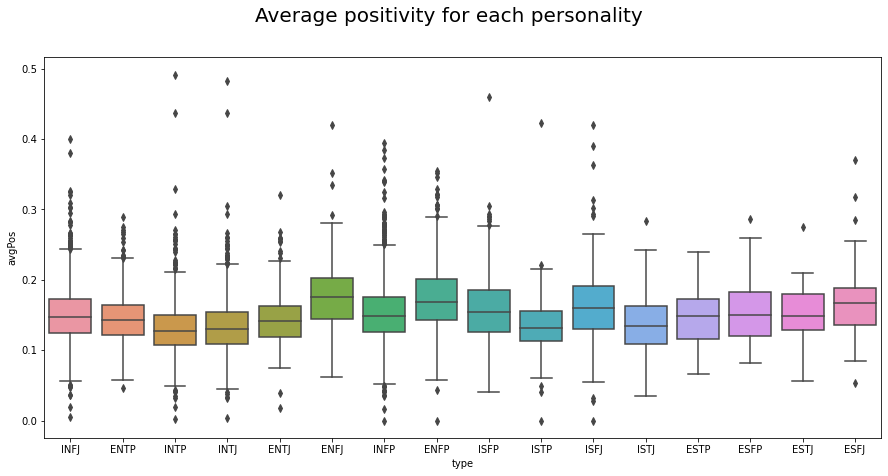

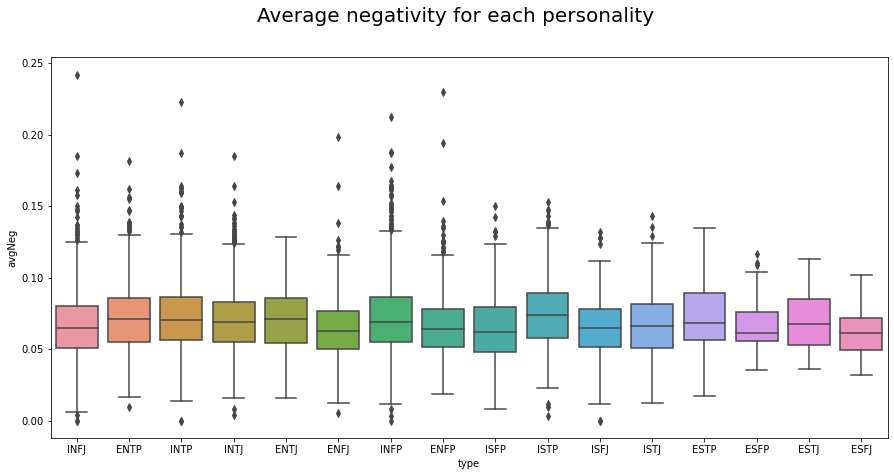

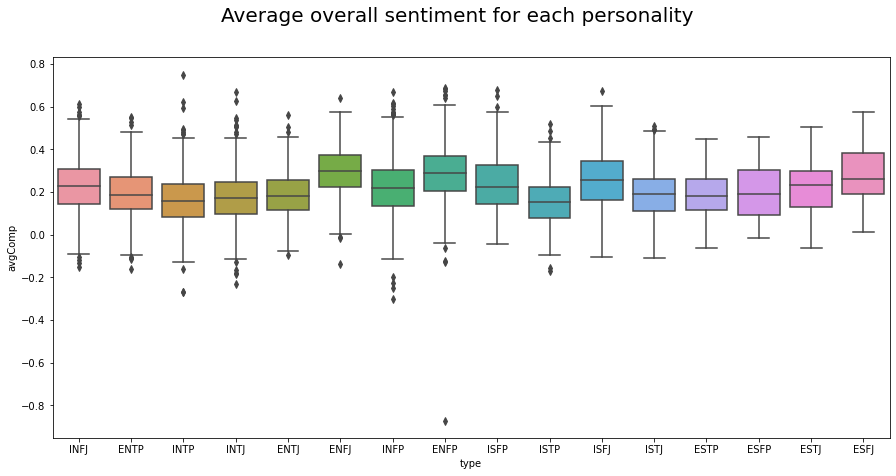

In [20]:
plt.figure(figsize=(15,7)).suptitle("Average positivity for each personality", fontsize=20)
sns.boxplot(x='type', y='avgPos', data=df)

plt.figure(figsize=(15,7)).suptitle("Average negativity for each personality", fontsize=20)
sns.boxplot(x='type', y='avgNeg', data=df)

plt.figure(figsize=(15,7)).suptitle("Average overall sentiment for each personality", fontsize=20)
sns.boxplot(x='type', y='avgComp', data=df)

Now with those features we will try a few different models
- Logistic Regression
- Random Forest
- K-Nearest Neighbour (KNN)
- Balanced Random Forest (after SMOTE oversampler and Tomek cleaning)

Logistic Regression score for the dichotomy I-E :
Accuracy on train set:	0.76652
Accuracy on test set:	0.77593

Logistic Regression score for the dichotomy N-S :
Accuracy on train set:	0.86197
Accuracy on test set:	0.86215

Logistic Regression score for the dichotomy T-F :
Accuracy on train set:	0.61267
Accuracy on test set:	0.61734

Logistic Regression score for the dichotomy J-P :
Accuracy on train set:	0.60114
Accuracy on test set:	0.61319

Average Logistic Regression score:	0.71715


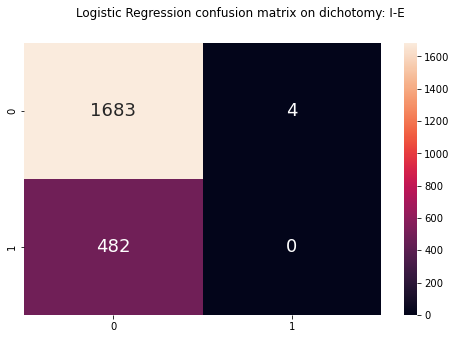

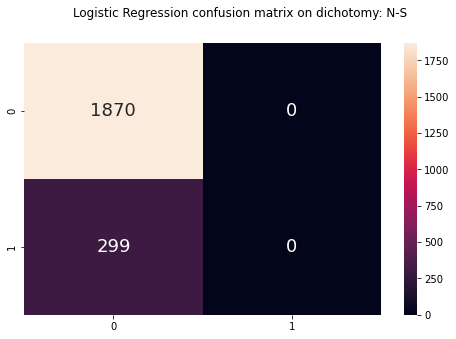

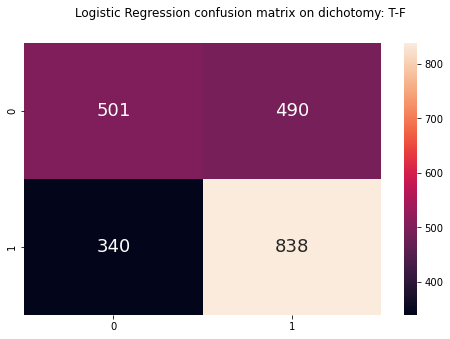

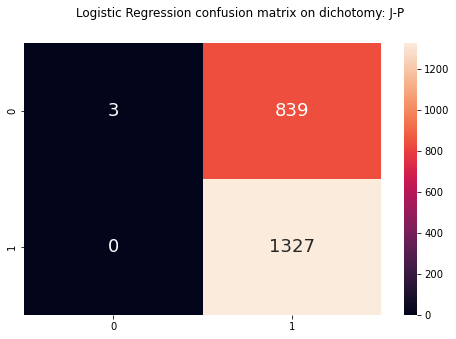

In [21]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgNeg', 'avgNeu', 'avgPos', 'avgComp']]
    y = df[dich]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)

    lgr = LogisticRegression()
    lgr.fit(x_train, y_train)
    pred = lgr.predict(x_test)
    trainScore = lgr.score(x_train, y_train)
    testScore = lgr.score(x_test, y_test)
    totalScore += testScore
    print("Logistic Regression score for the dichotomy", dich, ":")
    print("Accuracy on train set:\t{:.5f}".format(trainScore))
    print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
    title = "Logistic Regression confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})
    
print("Average Logistic Regression score:\t{:.5f}".format(totalScore/4))

Random Forest score for the dichotomy I-E :
Accuracy on train set:	1.00000
Accuracy on test set:	0.76072

Random Forest score for the dichotomy N-S :
Accuracy on train set:	1.00000
Accuracy on test set:	0.85293

Random Forest score for the dichotomy T-F :
Accuracy on train set:	1.00000
Accuracy on test set:	0.58552

Random Forest score for the dichotomy J-P :
Accuracy on train set:	1.00000
Accuracy on test set:	0.55832

Average Random Forest score:	0.68937


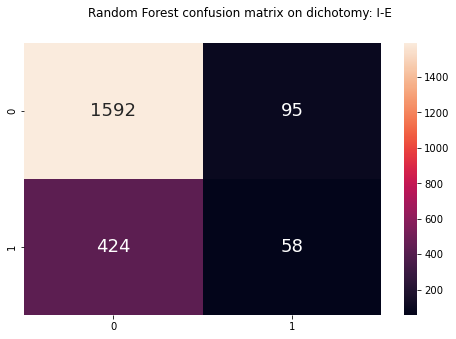

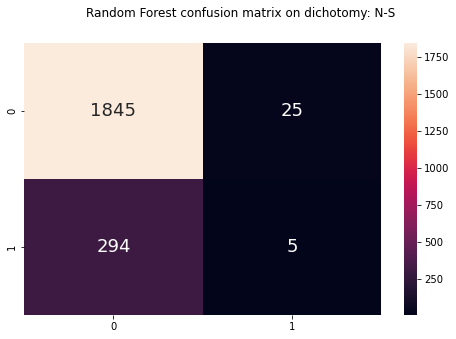

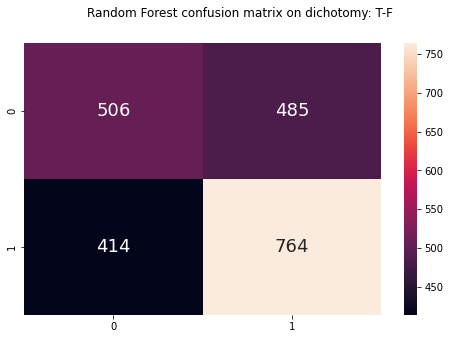

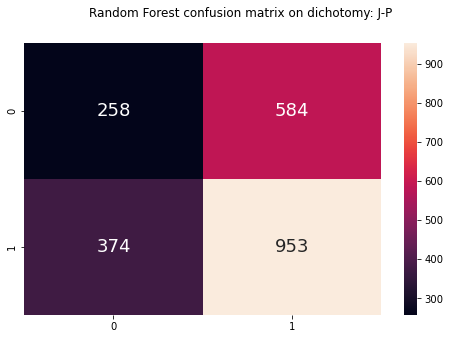

In [22]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgNeg', 'avgNeu', 'avgPos', 'avgComp']]
    y = df[dich]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)

    rdf = RandomForestClassifier()
    rdf.fit(x_train, y_train)
    pred = rdf.predict(x_test)
    trainScore = rdf.score(x_train, y_train)
    testScore = rdf.score(x_test, y_test)
    totalScore += testScore
    print("Random Forest score for the dichotomy", dich, ":")
    print("Accuracy on train set:\t{:.5f}".format(trainScore))
    print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
    title = "Random Forest confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})
    
print("Average Random Forest score:\t{:.5f}".format(totalScore/4))

Best average score uses 89 neighbours.

K-Nearest Neighbours score for the dichotomy I-E :
Accuracy on train set:	0.76698
Accuracy on test set:	0.77778

K-Nearest Neighbours score for the dichotomy N-S :
Accuracy on train set:	0.86197
Accuracy on test set:	0.86215

K-Nearest Neighbours score for the dichotomy T-F :
Accuracy on train set:	0.62927
Accuracy on test set:	0.62794

K-Nearest Neighbours score for the dichotomy J-P :
Accuracy on train set:	0.60252
Accuracy on test set:	0.60950

Average K-Nearest Neighbours score:	0.71934



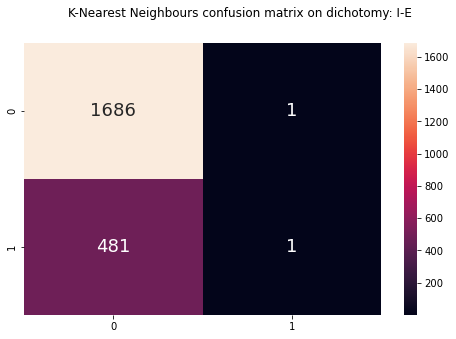

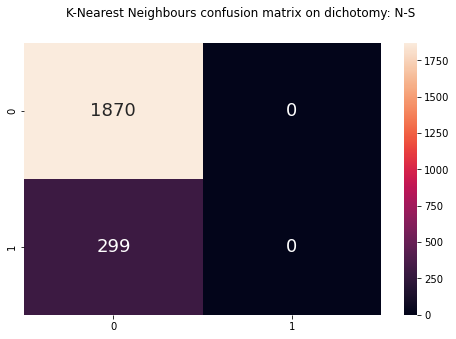

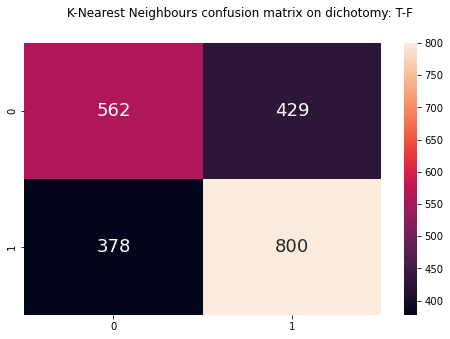

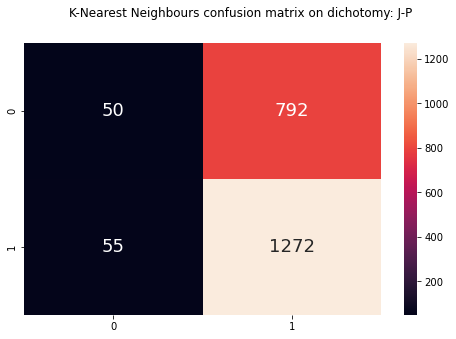

In [23]:
scoreList = []
for i in range(1,100):
    #print("Using {:d} neighbours".format(i))

    totalScore = 0
    
    for dich in ['I-E','N-S','T-F','J-P']:
        x = df[['avgNeg', 'avgNeu', 'avgPos', 'avgComp']]
        y = df[dich]
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)

        knn = KNeighborsClassifier(n_neighbors = i)    
        knn.fit(x_train, y_train)
        pred = knn.predict(x_test)
        trainScore = knn.score(x_train, y_train)
        testScore = knn.score(x_test, y_test)
        totalScore += testScore
        #print("KNN score for the dichotomy", dich, ":")
        #print("Accuracy on train set:\t{:.5f}".format(trainScore))
        #print("Accuracy on test set:\t{:.5f}\n".format(testScore))
        
    #print("Average KNN score:\t{:.5f}\n".format(totalScore/4))
    scoreList.append(totalScore/4)

bestIndex = scoreList.index(max(scoreList)) + 1
print("Best average score uses {:d} neighbours.\n".format(bestIndex))

totalScore = 0
for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgNeg', 'avgNeu', 'avgPos', 'avgComp']]
    y = df[dich]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)

    knn = KNeighborsClassifier(n_neighbors = bestIndex)    
    knn.fit(x_train, y_train)
    pred = knn.predict(x_test)
    trainScore = knn.score(x_train, y_train)
    testScore = knn.score(x_test, y_test)
    totalScore += testScore
    print("K-Nearest Neighbours score for the dichotomy", dich, ":")
    print("Accuracy on train set:\t{:.5f}".format(trainScore))
    print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
    title = "K-Nearest Neighbours confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})
    
print("Average K-Nearest Neighbours score:\t{:.5f}\n".format(totalScore/4))

Balanced Random Forest score for the dichotomy I-E :
Accuracy on train set:	1.00000
Accuracy on test set:	0.77277

Balanced Random Forest score for the dichotomy N-S :
Accuracy on train set:	0.99991
Accuracy on test set:	0.81730

Balanced Random Forest score for the dichotomy T-F :
Accuracy on train set:	1.00000
Accuracy on test set:	0.68282

Balanced Random Forest score for the dichotomy J-P :
Accuracy on train set:	1.00000
Accuracy on test set:	0.65608

Average Balanced Random Forest score:	0.73224


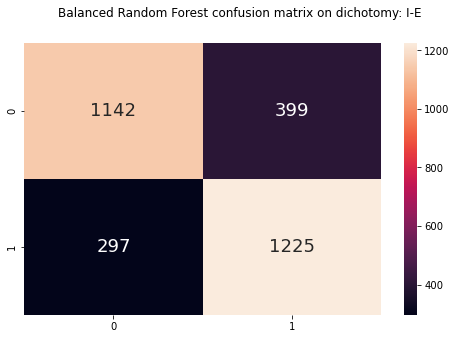

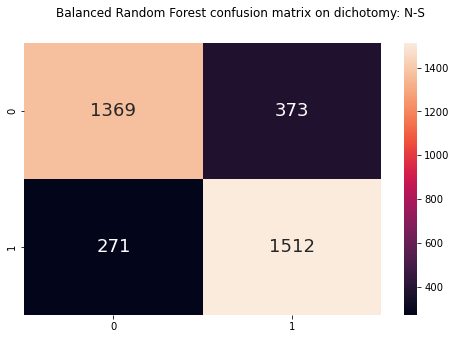

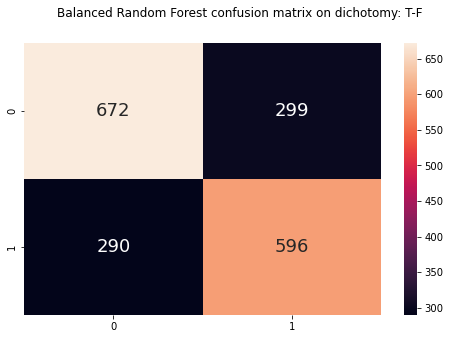

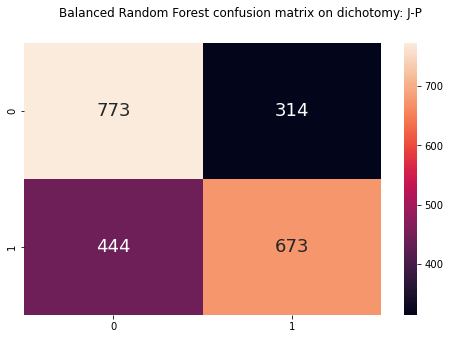

In [24]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgNeg', 'avgNeu', 'avgPos', 'avgComp']]
    y = df[dich]
    x_resampled, y_resampled = SMOTETomek(random_state=5).fit_resample(x, y)
    x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=5)

    brf = BalancedRandomForestClassifier()
    brf.fit(x_train, y_train)
    pred = brf.predict(x_test)
    trainScore = brf.score(x_train, y_train)
    testScore = brf.score(x_test, y_test)
    totalScore += testScore
    print("Balanced Random Forest score for the dichotomy", dich, ":")
    print("Accuracy on train set:\t{:.5f}".format(trainScore))
    print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
    title = "Balanced Random Forest confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})
    
print("Average Balanced Random Forest score:\t{:.5f}".format(totalScore/4))

Now that we have concluded that Balanced Random Forest is the best, we will try some feature manipulation and engineering to try and improve the accuracy of the model. First we will try using just the individual different sentiment analysis scores.

In [25]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgPos']]
    y = df[dich]
    x_resampled, y_resampled = SMOTETomek(random_state=5).fit_resample(x, y)
    x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=5)

    brf = BalancedRandomForestClassifier()
    brf.fit(x_train, y_train)
    pred = brf.predict(x_test)
    trainScore = brf.score(x_train, y_train)
    testScore = brf.score(x_test, y_test)
    totalScore += testScore
    #print("Balanced Random Forest score for the dichotomy", dich, ":")
    #print("Accuracy on train set:\t{:.5f}".format(trainScore))
    #print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
print("Average Balanced Random Forest score using 'avgPos':\t{:.5f}".format(totalScore/4))

Average Balanced Random Forest score using 'avgPos':	0.66509


In [26]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgNeg']]
    y = df[dich]
    x_resampled, y_resampled = SMOTETomek(random_state=5).fit_resample(x, y)
    x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=5)

    brf = BalancedRandomForestClassifier()
    brf.fit(x_train, y_train)
    pred = brf.predict(x_test)
    trainScore = brf.score(x_train, y_train)
    testScore = brf.score(x_test, y_test)
    totalScore += testScore
    #print("Balanced Random Forest score for the dichotomy", dich, ":")
    #print("Accuracy on train set:\t{:.5f}".format(trainScore))
    #print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
print("Average Balanced Random Forest score using 'avgNeg':\t{:.5f}".format(totalScore/4))

Average Balanced Random Forest score using 'avgNeg':	0.65043


In [27]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgNeu']]
    y = df[dich]
    x_resampled, y_resampled = SMOTETomek(random_state=5).fit_resample(x, y)
    x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=5)

    brf = BalancedRandomForestClassifier()
    brf.fit(x_train, y_train)
    pred = brf.predict(x_test)
    trainScore = brf.score(x_train, y_train)
    testScore = brf.score(x_test, y_test)
    totalScore += testScore
    #print("Balanced Random Forest score for the dichotomy", dich, ":")
    #print("Accuracy on train set:\t{:.5f}".format(trainScore))
    #print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
print("Average Balanced Random Forest score using 'avgNeu':\t{:.5f}".format(totalScore/4))

Average Balanced Random Forest score using 'avgNeu':	0.66757


In [28]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgComp']]
    y = df[dich]
    x_resampled, y_resampled = SMOTETomek(random_state=5).fit_resample(x, y)
    x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=5)

    brf = BalancedRandomForestClassifier()
    brf.fit(x_train, y_train)
    pred = brf.predict(x_test)
    trainScore = brf.score(x_train, y_train)
    testScore = brf.score(x_test, y_test)
    totalScore += testScore
    #print("Balanced Random Forest score for the dichotomy", dich, ":")
    #print("Accuracy on train set:\t{:.5f}".format(trainScore))
    #print("Accuracy on test set:\t{:.5f}\n".format(testScore))

print("Average Balanced Random Forest score using 'avgComp':\t{:.5f}".format(totalScore/4))

Average Balanced Random Forest score using 'avgComp':	0.76062


We can see that just using 'avgComp' we get the best accuracy. Now we will try combining features with the earlier tests to see if we can further improve accuracy.

Balanced Random Forest score for the dichotomy I-E :
Accuracy on train set:	1.00000
Accuracy on test set:	0.84264

Balanced Random Forest score for the dichotomy N-S :
Accuracy on train set:	1.00000
Accuracy on test set:	0.91990

Balanced Random Forest score for the dichotomy T-F :
Accuracy on train set:	1.00000
Accuracy on test set:	0.71976

Balanced Random Forest score for the dichotomy J-P :
Accuracy on train set:	1.00000
Accuracy on test set:	0.66468

Average Balanced Random Forest score using all features:	0.78675


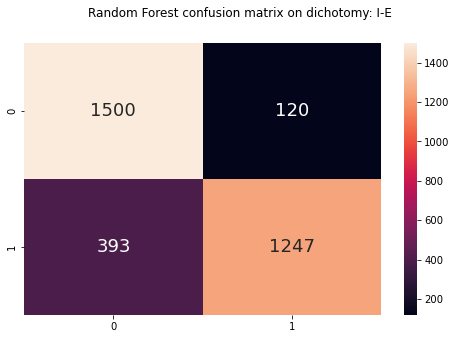

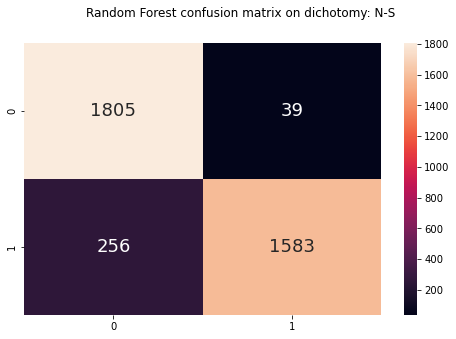

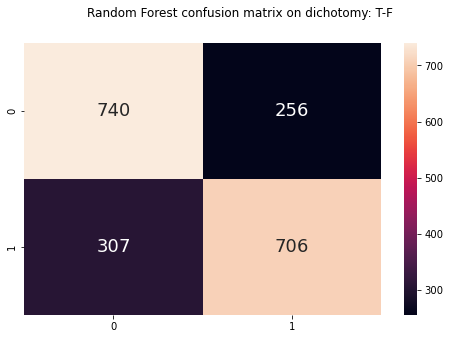

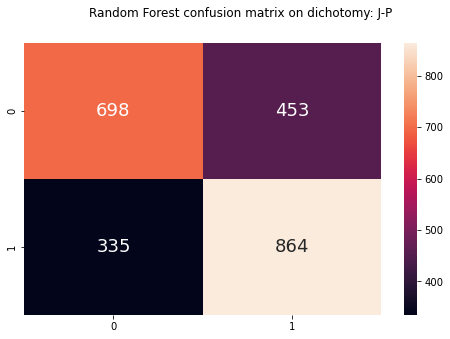

In [29]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgComp','time_per_comment','be_per_comment','articles_per_comment',
            'think_per_comment','feel_per_comment','judge_per_comment']]
    y = df[dich]
    x_resampled, y_resampled = SMOTETomek(random_state=5).fit_resample(x, y)
    x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=5)

    brf = BalancedRandomForestClassifier()
    brf.fit(x_train, y_train)
    pred = brf.predict(x_test)
    trainScore = brf.score(x_train, y_train)
    testScore = brf.score(x_test, y_test)
    totalScore += testScore
    print("Balanced Random Forest score for the dichotomy", dich, ":")
    print("Accuracy on train set:\t{:.5f}".format(trainScore))
    print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
    title = "Random Forest confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})

print("Average Balanced Random Forest score using all features:\t{:.5f}".format(totalScore/4))

Balanced Random Forest prediction on all 16 personalities:
Accuracy on train set (balanced):  1.0
Accuracy on test set (balanced):  0.7423738615006505 

Accuracy on 75% set (raw data):  0.7946510913003382
Accuracy on 25% set (raw data):  0.7916090364223144


<AxesSubplot:>

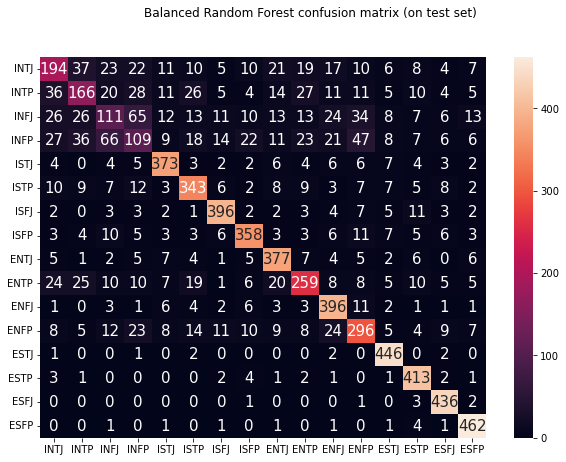

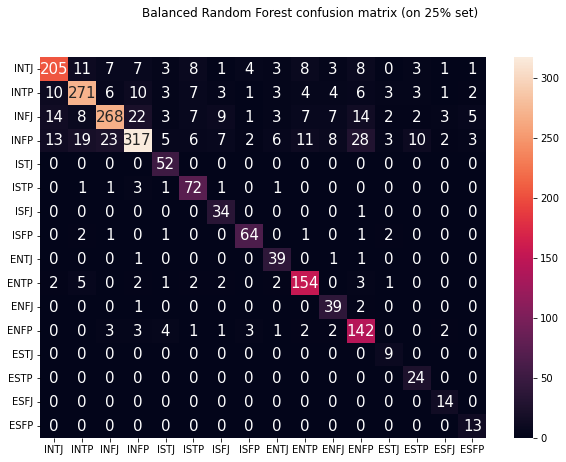

In [30]:
X = df.drop(['type','posts','I-E','N-S','T-F','J-P','avgPos','avgNeg','avgNeu'], axis=1).values
y = df['type'].values
X_resampled, y_resampled = SMOTETomek().fit_resample(X, y)

X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size = 0.25, random_state=5)
random_forest = BalancedRandomForestClassifier()
random_forest.fit(X_train, y_train)

print("Balanced Random Forest prediction on all 16 personalities:")
print("Accuracy on train set (balanced): ", random_forest.score(X_train, y_train))
print("Accuracy on test set (balanced): ", random_forest.score(X_test, y_test), "\n")

Ximb_train,Ximb_test,yimb_train,yimb_test=train_test_split(X,y,test_size = 0.25, random_state=5)

print("Accuracy on 75% set (raw data): ", random_forest.score(Ximb_train, yimb_train))
print("Accuracy on 25% set (raw data): ", random_forest.score(Ximb_test, yimb_test))

y_test_pred = random_forest.predict(X_test)
yimb_test_pred = random_forest.predict(Ximb_test)

plt.figure(figsize=(10,7)).suptitle("Balanced Random Forest confusion matrix (on test set)")
perslist = ['INTJ', 'INTP', 'INFJ', 'INFP', 'ISTJ', 'ISTP', 'ISFJ', 'ISFP', 'ENTJ', 'ENTP', 'ENFJ', 'ENFP', 'ESTJ', 'ESTP', 'ESFJ', 'ESFP']
sns.heatmap(confusion_matrix(y_test, y_test_pred, labels=perslist), 
    annot = True, fmt=".0f", annot_kws={"size": 15}, xticklabels=perslist, yticklabels=perslist)

plt.figure(figsize=(10,7)).suptitle("Balanced Random Forest confusion matrix (on 25% set)")
sns.heatmap(confusion_matrix(yimb_test, yimb_test_pred, labels=perslist), 
    annot = True, fmt=".0f", annot_kws={"size": 15}, xticklabels=perslist, yticklabels=perslist)

It can be noted that while Balanced Random Forest has the highest accuracy, it has 100% accuracy on train sets, possibly indicating overfitting, we will try running the features through the second best classification model, Logistic Regression, along with SMOTE oversampler and Tomek cleaning just to see if we can potentially get a better model for a wider use scenario.

Logistic Regression score for the dichotomy I-E :
Accuracy on train set:	0.76683
Accuracy on test set:	0.77732

Logistic Regression score for the dichotomy N-S :
Accuracy on train set:	0.86197
Accuracy on test set:	0.86215

Logistic Regression score for the dichotomy T-F :
Accuracy on train set:	0.67246
Accuracy on test set:	0.66482

Logistic Regression score for the dichotomy J-P :
Accuracy on train set:	0.60160
Accuracy on test set:	0.61180

Average Logistic Regression score:	0.72902


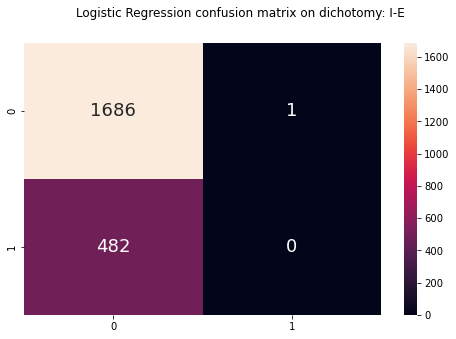

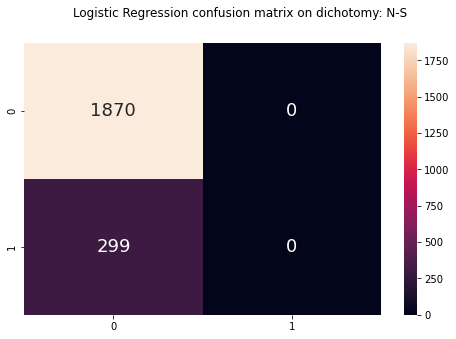

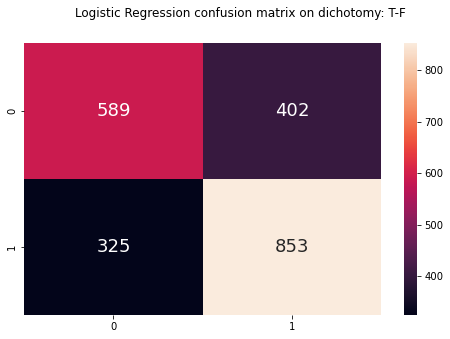

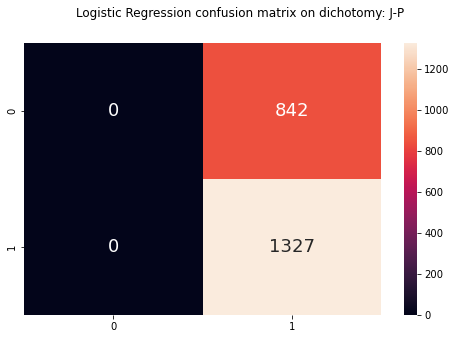

In [31]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgComp','time_per_comment','be_per_comment','articles_per_comment',
            'think_per_comment','feel_per_comment','judge_per_comment']]
    y = df[dich]
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=5)

    lgr = LogisticRegression()
    lgr.fit(x_train, y_train)
    pred = lgr.predict(x_test)
    trainScore = lgr.score(x_train, y_train)
    testScore = lgr.score(x_test, y_test)
    totalScore += testScore
    print("Logistic Regression score for the dichotomy", dich, ":")
    print("Accuracy on train set:\t{:.5f}".format(trainScore))
    print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
    title = "Logistic Regression confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})
    
print("Average Logistic Regression score:\t{:.5f}".format(totalScore/4))

Logistic Regression score for the dichotomy I-E :
Accuracy on train set:	0.58102
Accuracy on test set:	0.59533

Logistic Regression score for the dichotomy N-S :
Accuracy on train set:	0.55003
Accuracy on test set:	0.55310

Logistic Regression score for the dichotomy T-F :
Accuracy on train set:	0.69620
Accuracy on test set:	0.69269

Logistic Regression score for the dichotomy J-P :
Accuracy on train set:	0.53808
Accuracy on test set:	0.52871

Average Logistic Regression score:	0.59246


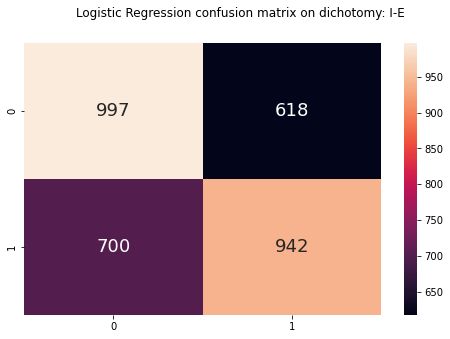

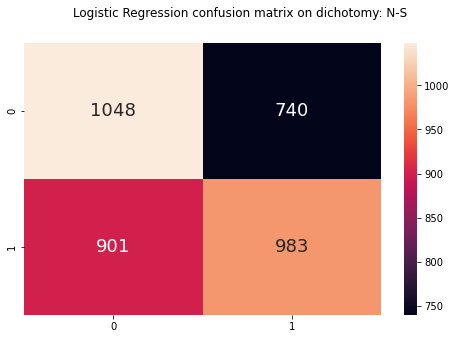

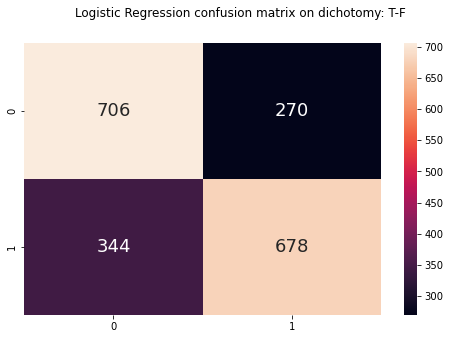

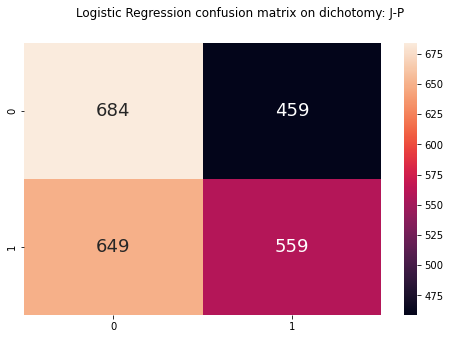

In [32]:
totalScore = 0

for dich in ['I-E','N-S','T-F','J-P']:
    x = df[['avgComp','time_per_comment','be_per_comment','articles_per_comment',
            'think_per_comment','feel_per_comment','judge_per_comment']]
    y = df[dich]
    x_resampled, y_resampled = SMOTETomek().fit_resample(x, y)
    x_train, x_test, y_train, y_test = train_test_split(x_resampled, y_resampled, test_size=0.25, random_state=5)

    lgr = LogisticRegression()
    lgr.fit(x_train, y_train)
    pred = lgr.predict(x_test)
    trainScore = lgr.score(x_train, y_train)
    testScore = lgr.score(x_test, y_test)
    totalScore += testScore
    print("Logistic Regression score for the dichotomy", dich, ":")
    print("Accuracy on train set:\t{:.5f}".format(trainScore))
    print("Accuracy on test set:\t{:.5f}\n".format(testScore))
    
    title = "Logistic Regression confusion matrix on dichotomy: " + dich
    plt.figure(figsize=(8,5)).suptitle(title)
    sns.heatmap(confusion_matrix(y_test, pred), 
        annot = True, fmt=".0f", annot_kws={"size": 18})
    
print("Average Logistic Regression score:\t{:.5f}".format(totalScore/4))

Unfortunately, if we do not balance the data, every dichotomy except T-F is heavily skewed, and if balanced, the accuracy is significantly lower. Therefore we can conclude that Balanced Random Forest, although overfitted, still has reasonable accuracy on the raw data, and thus is the best model.